## ML Exploratory Data Analysis (EDA)

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Load Dataset

- **Description of features**
    - **time_met**: Time variable of meteorological measurements.
    - **crain**: Categorical variable indicating rain (1 = raining, 0 = not raining).
    - **mslp**: Mean sea level pressure (Pa).
    - **tcc**: Total cloud cover (%).
    - **tp**: Total precipitation (kg/m²).
    - **u10**: U-component of 10-meter wind speed (m/s).
    - **v10**: V-component of 10-meter wind speed (m/s).
    - **wl_pred**: Predicted (tidal) water level (m NAVD88).

<br>

- **Description of target**
    - **wl_obs**: Observed water level – this is the variable we want to predict (m NAVD88).


In [3]:
df = pd.read_csv('wl_ts_data.csv')
df.head()

,crain,mslp,tcc,time_met,time_wl_obs,time_wl_pred,tp,u10,v10,wl_obs,wl_pred
0,0,102288.453125,34.0,01-Apr-2023 00:00:00,01-Apr-2023 00:00:00,01-Apr-2023 00:00:00,0.0000,0.325853,6.476738,NaN,NaN
1,1,102235.359375,64.0,01-Apr-2023 01:00:00,01-Apr-2023 01:00:00,01-Apr-2023 01:00:00,0.1875,1.586587,7.188092,NaN,NaN
2,0,102312.179688,33.0,01-Apr-2023 02:00:00,01-Apr-2023 02:00:00,01-Apr-2023 02:00:00,0.2500,2.637323,7.356561,NaN,NaN
3,1,102246.250000,100.0,01-Apr-2023 03:00:00,01-Apr-2023 03:00:00,01-Apr-2023 03:00:00,0.2500,2.927865,6.998579,NaN,-0.492595
4,0,102147.679688,56.0,01-Apr-2023 04:00:00,01-Apr-2023 04:00:00,01-Apr-2023 04:00:00,0.2500,3.255474,7.011000,NaN,-0.376565


In [5]:
# Drop columns
df = df.drop(['time_wl_obs','time_wl_pred'], axis=1)

# Drop rows
start_date = pd.to_datetime('2023-04-01 04:00:00')
end_date = pd.to_datetime('2024-04-30 04:00:00')

df['time_met'] = pd.to_datetime(df['time_met'])
df = df[(df['time_met'] > start_date) & (df['time_met'] < end_date)].reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9479 entries, 0 to 9478
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   crain     9479 non-null   int64         
 1   mslp      9479 non-null   float64       
 2   tcc       9479 non-null   float64       
 3   time_met  9479 non-null   datetime64[ns]
 4   tp        9479 non-null   float64       
 5   u10       9479 non-null   float64       
 6   v10       9479 non-null   float64       
 7   wl_obs    9479 non-null   float64       
 8   wl_pred   9479 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 666.6 KB


### Distribution of Features & Target

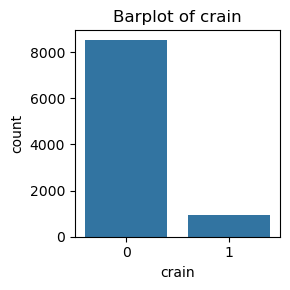

In [7]:
plt.figure(figsize=(3, 3))

# Categorical columns
cat_cols = ['crain']

for i, col in enumerate(cat_cols, start=1):
    # Bar plot
    plt.subplot(len(cat_cols), 1, i)
    sns.countplot(data=df, x=col)
    plt.title(f"Barplot of {col}")

plt.tight_layout()
plt.show()

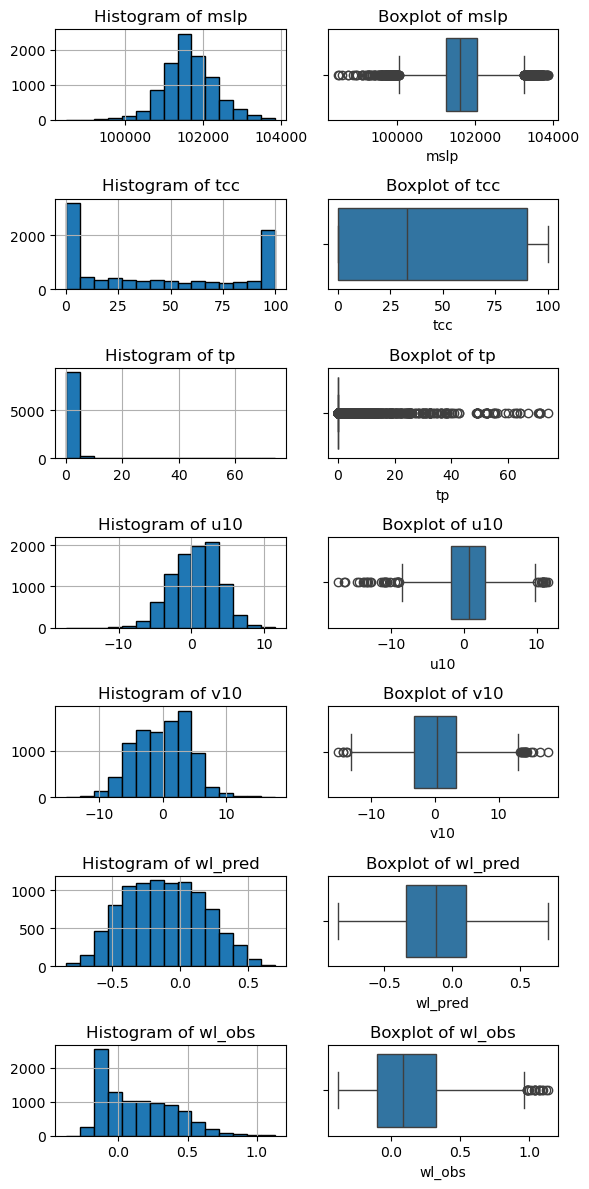

In [9]:
plt.figure(figsize=(6, 12))

# Numerical columns
num_cols = ['mslp','tcc','tp','u10','v10','wl_pred','wl_obs']

for i, col in enumerate(num_cols, start=1):
    # Left column: Histogram
    plt.subplot(len(num_cols), 2, 2*i-1)
    df[col].hist(bins=15, edgecolor='black')
    plt.title(f"Histogram of {col}")
    
    # Right column: Box plot
    plt.subplot(len(num_cols), 2, 2*i)
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

### Correlation Analysis

In [11]:
# Create a column transformer for data normalization
minmax_cols = ['tcc', 'wl_obs']
zscore_cols = ['mslp','tp','u10','v10','wl_pred']
remain_cols = ['crain','time_met']

preprocessor = ColumnTransformer(transformers=[
    ('minmax', MinMaxScaler(), minmax_cols),
    ('zscore', StandardScaler(), zscore_cols),
], remainder='passthrough')

# Convert the result back into a DataFrame
df_T = preprocessor.fit_transform(df)
df_T = pd.DataFrame(df_T, columns = minmax_cols + zscore_cols + remain_cols)

# Reorganize the sequence of columns
df_T = df_T.drop(['time_met'], axis=1)
df_T = pd.DataFrame(df_T, columns=['tcc','mslp','tp','u10','v10','wl_pred','crain','wl_obs'])

df_T.head()

,tcc,mslp,tp,u10,v10,wl_pred,crain,wl_obs
0,0.26,0.642141,-0.155997,0.934781,1.709582,-0.511492,0,0.22308
1,0.21,0.556984,-0.155997,1.167535,1.870964,-0.108086,0,0.304931
2,0.23,0.414684,-0.155997,1.205291,1.913952,0.29532,0,0.394163
3,0.22,0.325883,-0.155997,1.259581,1.889916,0.698726,0,0.46528
4,0.27,0.249103,-0.155997,1.296538,1.971664,1.102132,0,0.522979


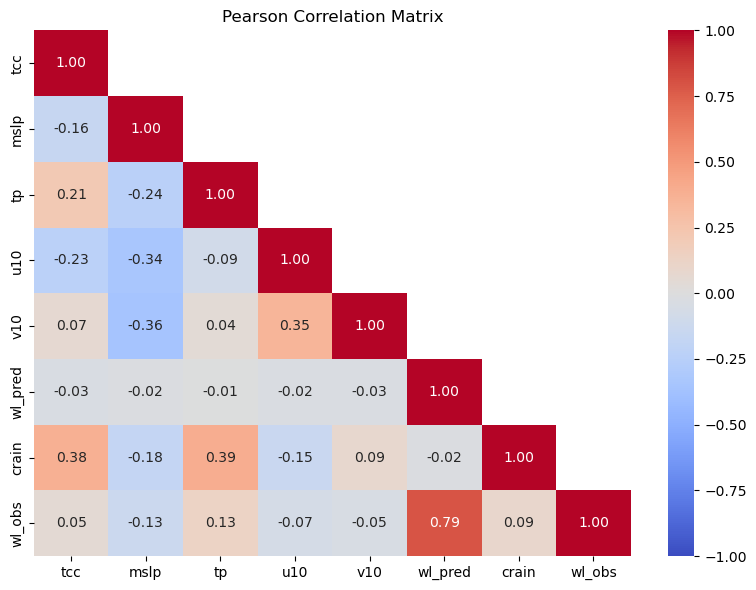

In [13]:
plt.figure(figsize=(8, 6))

df_corr = df_T.corr()
sns.heatmap(df_corr, vmin=-1, vmax=1, center=0, fmt='.2f', annot=True, 
            cmap='coolwarm', mask=np.triu(np.ones_like(df_corr), 1))

plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.show()